# Курс Рекомендательные системы

# Практическое задание урока 5. Ранжирование и Гибридные рекомендательные системы
1. Прочитать статьи про BPR, WARP loss

2. Сделать грид серч текущей модели

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix, coo_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

from lightfm import LightFM
from lightfm.evaluation import precision_at_k, recall_at_k

# Функции из 1-ого вебинара
import os, sys

module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
# from src.metrics import precision_at_k, recall_at_k
from utils import prefilter_items

C:\ProgramData\Anaconda3\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [2]:
data = pd.read_csv('retail_train.csv')

item_features = pd.read_csv('product.csv')
user_features = pd.read_csv('hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)

# train test split
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [3]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [4]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [5]:
user_features['age_desc'].unique()

array(['65+', '45-54', '25-34', '35-44', '19-24', '55-64'], dtype=object)

In [6]:
user_features['marital_status_code'].unique()

array(['A', 'U', 'B'], dtype=object)

In [7]:
user_features['household_size_desc'].unique()

array(['2', '3', '4', '1', '5+'], dtype=object)

## 1. Filter items

In [8]:
data_train.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [9]:
n_items_train_before = data_train['item_id'].nunique()
n_items_test_before = data_test['item_id'].nunique()
n_users_train_before = data_train['user_id'].nunique()
n_users_test_before = data_test['user_id'].nunique()

data_train_filtered = prefilter_items(data_train, take_n_popular=5000, item_features=item_features)
data_test_filtered = prefilter_items(data_test, take_n_popular=5000, item_features=item_features)

n_items_train_after = data_train_filtered['item_id'].nunique()
n_items_test_after = data_test_filtered['item_id'].nunique()
n_users_train_after = data_train_filtered['user_id'].nunique()
n_users_test_after = data_test_filtered['user_id'].nunique()
print('Decreased # items_train from {} to {}'.format(n_items_train_before, n_items_train_after))
print('Decreased # items_test from {} to {}'.format(n_items_test_before, n_items_test_after))
print('Decreased # users_train from {} to {}'.format(n_users_train_before, n_users_train_after))
print('Decreased # users_test from {} to {}'.format(n_users_test_before, n_users_test_after))

Decreased # items_train from 86865 to 5001
Decreased # items_test from 24329 to 5001
Decreased # users_train from 2499 to 2497
Decreased # users_test from 2042 to 1990


# 2. Prepare data set

## 2.1 Prepare csr train matrix

In [10]:
user_item_matrix = pd.pivot_table(data_train_filtered, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробоват ьдругие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(2)

item_id,117847,818981,819255,819308,819400,819487,819590,819594,819840,819845,...,15926775,15926844,15926886,15972074,15972298,15972565,15972790,16100266,16729299,16729415
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 2.2 Prepare CSR test matrix

In [11]:
data_test = data_test[data_test['item_id'].isin(data_train['item_id'].unique())]

test_user_item_matrix = pd.pivot_table(data_test_filtered, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробовать другие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

test_user_item_matrix = test_user_item_matrix.astype(float) # необходимый тип матрицы для implicit
test_user_item_matrix.head(2)

item_id,819210,819308,819423,819487,819840,819845,819978,820321,820347,820352,...,17381676,17381995,17827241,17900997,17901020,17903379,17903423,17959083,18000012,18024556
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

## 3. Prepare user and item features

In [13]:
user_feat = pd.DataFrame(user_item_matrix.index)
user_feat = user_feat.merge(user_features, on='user_id', how='left')
user_feat.set_index('user_id', inplace=True)
user_feat.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
user_id,,,,,,,
1,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
user_feat.shape

(2497, 7)

In [15]:
item_feat = pd.DataFrame(user_item_matrix.columns)
item_feat = item_feat.merge(item_features, on='item_id', how='left')
item_feat.set_index('item_id', inplace=True)

item_feat.head(2)

,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
item_id,,,,,,
117847,450.0,NUTRITION,National,REFRIGERATED,SOY/RICE MILK,64 OZ
818981,194.0,GROCERY,National,COLD CEREAL,ALL FAMILY CEREAL,10.4 OZ


In [16]:
item_feat.shape

(5001, 6)

## Encoding features

In [17]:
user_feat_lightfm = pd.get_dummies(user_feat, columns=user_feat.columns.tolist())
item_feat_lightfm = pd.get_dummies(item_feat, columns=item_feat.columns.tolist())

In [18]:
user_feat_lightfm.head(2)

,age_desc_19-24,age_desc_25-34,age_desc_35-44,age_desc_45-54,age_desc_55-64,age_desc_65+,marital_status_code_A,marital_status_code_B,marital_status_code_U,income_desc_100-124K,...,hh_comp_desc_Unknown,household_size_desc_1,household_size_desc_2,household_size_desc_3,household_size_desc_4,household_size_desc_5+,kid_category_desc_1,kid_category_desc_2,kid_category_desc_3+,kid_category_desc_None/Unknown
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,1,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Init model

In [19]:
model = LightFM(no_components=40,
#                 loss='bpr',
                loss='warp',
                learning_rate=0.05, 
                item_alpha=0.1,
                user_alpha=0.1, 
                random_state=42)

## Train

In [20]:
%%time

model.fit((sparse_user_item > 0) * 1,  # user-item matrix из 0 и 1
          sample_weight=coo_matrix(user_item_matrix),
          user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
          item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
          epochs=15, 
          num_threads=4,
          verbose=False) 

Wall time: 4min 15s


# Evaluation

In [21]:
user_emb = model.get_user_representations(features=csr_matrix(user_feat_lightfm.values).tocsr())

In [22]:
user_emb[0]  # biases

array([-11.807905,   0.      ,   0.      , ..., -12.272686,  -8.767859,
         0.      ], dtype=float32)

In [23]:
user_emb[0].shape

(2497,)

In [24]:
user_emb[1]  # embeddings

array([[ 5.6503309e-09, -3.0050511e-08,  1.0137632e-09, ...,
         9.8039621e-09, -7.0081212e-09, -2.8248593e-08],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       ...,
       [ 5.5196256e-09, -2.9651456e-08,  9.7045583e-10, ...,
         9.1339629e-09, -7.1890183e-09, -2.7860789e-08],
       [ 2.4233651e-09, -1.3516564e-08,  3.7408027e-10, ...,
         2.9918905e-09, -4.2692054e-09, -1.3731847e-08],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)

In [25]:
user_emb[1].shape

(2497, 40)

In [26]:
item_emb = model.get_item_representations(features=csr_matrix(item_feat_lightfm.values).tocsr())

In [27]:
item_emb[0].shape

(5001,)

In [28]:
item_emb[1].shape

(5001, 40)

# Train precision

In [29]:
train_precision = precision_at_k(model, sparse_user_item, 
                                 user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                 item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                 k=5).mean()

train_precision

0.29411295

In [30]:
test_item_ids = np.array([1, 2, 3, 200, 1200])

predictions = model.predict(user_ids=0,
                            item_ids=test_item_ids,
                            user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                            item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                            num_threads=4)

In [31]:
predictions

array([-11.81087  , -11.711367 , -11.675674 , -11.817369 , -11.9147415],
      dtype=float32)

# Test precision

In [32]:
test_precision = precision_at_k(model, csr_matrix(test_user_item_matrix).tocsr(), 
                                 user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                 item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                 k=5).mean()

test_precision

0.0028140703

Neural networks for RS: http://d2l.ai/chapter_recommender-systems/mf.html

LigthFM -> https://arxiv.org/pdf/1507.08439.pdf

https://making.lyst.com/lightfm/docs/home.html


predictions - некоторые числа. 

# Домашнее задание

1) Прочитать статьи про BPR, WARP loss

2) Сделать грид серч текущей модели

## Решение 1. Подбор параметров по сетке

In [33]:
import itertools

In [101]:
def grid_search(sparse_user_item, params, N=5):
    test_data = csr_matrix(test_user_item_matrix).tocsr()
    user_features = csr_matrix(user_feat_lightfm.values).tocsr()
    item_features = csr_matrix(item_feat_lightfm.values).tocsr()
    
    scores = []
    summary = []
    for components, loss, l_rate, alpha in itertools.product(*params.values()):
        model = LightFM(no_components=components,
                loss=loss,
                learning_rate=l_rate, 
                item_alpha=alpha,
                user_alpha=alpha, 
                random_state=42)
        
        model = model.fit((sparse_user_item > 0) * 1,
                           sample_weight=coo_matrix(user_item_matrix),
                           user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                           item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                           epochs=15, 
                           num_threads=4,
                           verbose=False) 
        
        test_precision = precision_at_k(model,
                                   test_data,
                                   user_features=user_features,
                                   item_features=item_features,
                                   k=N).mean()
                
        score = {'no_components': components,
                 'loss':          loss,
                 'learning_rate': l_rate,
                 'alpha':         alpha,
                 'test_precision':     test_precision}
        print(score)
        
        summary.append([components, loss, l_rate, alpha, test_precision])
    
    return summary

In [102]:
%%time

parameters = {'no_components': [10, 20, 40],
              'loss':          ['bpr'],
              'learning_rate': [0.01, 0.05, 0.1],
              'alpha':         [0.01, 0.05, 0.1]}

summary = grid_search(sparse_user_item, parameters, N=5)

{'no_components': 10, 'loss': 'bpr', 'learning_rate': 0.01, 'alpha': 0.01, 'test_precision': 0.002110553}
{'no_components': 10, 'loss': 'bpr', 'learning_rate': 0.01, 'alpha': 0.05, 'test_precision': 0.0028140706}
{'no_components': 10, 'loss': 'bpr', 'learning_rate': 0.01, 'alpha': 0.1, 'test_precision': 0.0028140706}
{'no_components': 10, 'loss': 'bpr', 'learning_rate': 0.05, 'alpha': 0.01, 'test_precision': 0.0028140706}
{'no_components': 10, 'loss': 'bpr', 'learning_rate': 0.05, 'alpha': 0.05, 'test_precision': 0.0028140706}
{'no_components': 10, 'loss': 'bpr', 'learning_rate': 0.05, 'alpha': 0.1, 'test_precision': 0.0025125628}
{'no_components': 10, 'loss': 'bpr', 'learning_rate': 0.1, 'alpha': 0.01, 'test_precision': 0.0028140706}
{'no_components': 10, 'loss': 'bpr', 'learning_rate': 0.1, 'alpha': 0.05, 'test_precision': 0.0033165829}
{'no_components': 10, 'loss': 'bpr', 'learning_rate': 0.1, 'alpha': 0.1, 'test_precision': 0.0033165829}
{'no_components': 20, 'loss': 'bpr', 'learni

In [103]:
summary_df = pd.DataFrame(data=summary, 
                            columns=['no_components', 'loss', 'learning_rate', 'alpha', 'test_precision'])

In [104]:
summary_df.sort_values('test_precision', ascending=False)

,no_components,loss,learning_rate,alpha,test_precision
7,10,bpr,0.10,0.05,0.003317
8,10,bpr,0.10,0.10,0.003317
16,20,bpr,0.10,0.05,0.002915
12,20,bpr,0.05,0.01,0.002814
11,20,bpr,0.01,0.10,0.002814
21,40,bpr,0.05,0.01,0.002814
20,40,bpr,0.01,0.10,0.002814
19,40,bpr,0.01,0.05,0.002814
15,20,bpr,0.10,0.01,0.002814
1,10,bpr,0.01,0.05,0.002814


In [105]:
summary_sorted = summary_df.sort_values('test_precision')

Графики для роста alpha


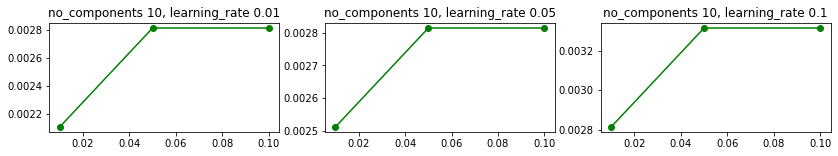

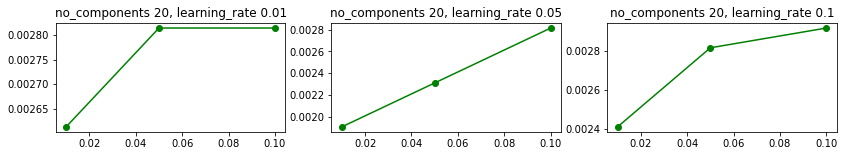

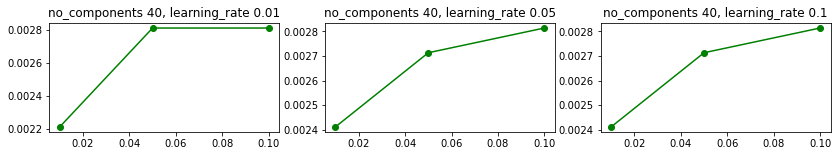

In [106]:
print('Графики для роста alpha')
for no_component in parameters.get('no_components'):
    f, ax = plt.subplots(1, 3, figsize=(14, 2))
    for i, l_r in enumerate(parameters.get('learning_rate')):
        ax[i].plot(parameters.get('alpha'),
                 summary_sorted['test_precision'].loc[(summary_sorted['no_components'] == no_component) \
                                          & (summary_sorted['learning_rate'] == l_r)].values,
                 'go-')
        
        
        ax[i].title.set_text('no_components ' + str(no_component) + ', learning_rate ' + str(l_r))

Графики для роста количества компонент


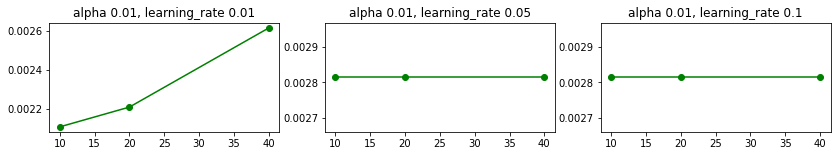

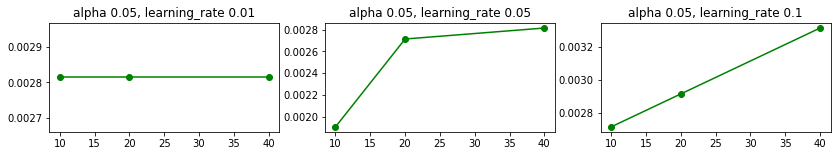

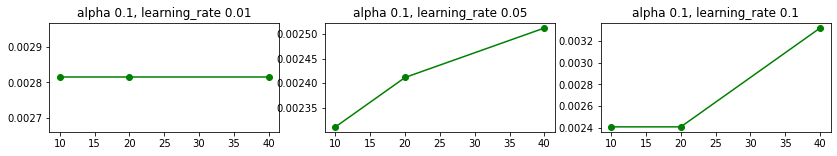

In [107]:
print('Графики для роста количества компонент')
for al in parameters.get('alpha'):
    f, ax = plt.subplots(1, 3, figsize=(14, 2))
    for i, l_r in enumerate(parameters.get('learning_rate')):
        ax[i].plot(parameters.get('no_components'),
                 summary_sorted['test_precision'].loc[(summary_sorted['alpha'] == al) \
                                          & (summary_sorted['learning_rate'] == l_r)].values,
                 'go-')
        
        
        ax[i].title.set_text('alpha ' + str(al) + ', learning_rate ' + str(l_r))

Графики для роста learning_rate


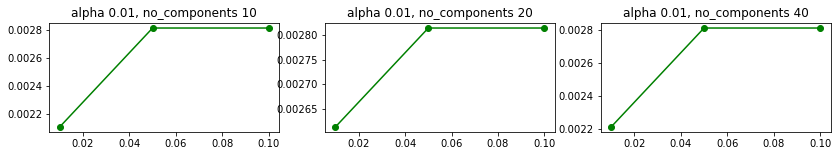

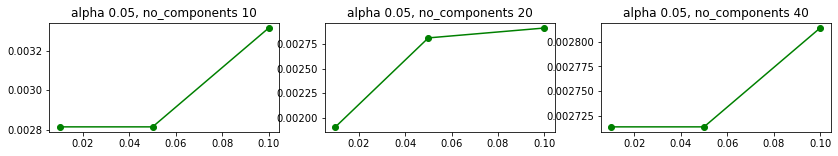

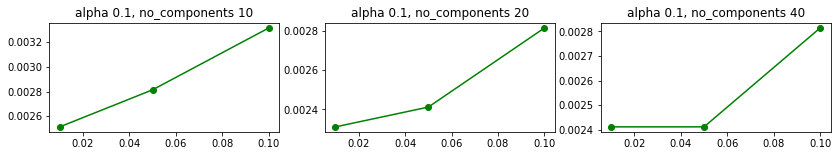

In [108]:
print('Графики для роста learning_rate')
for al in parameters.get('alpha'):
    f, ax = plt.subplots(1, 3, figsize=(14, 2))
    for i, no_component in enumerate(parameters.get('no_components')):
        ax[i].plot(parameters.get('learning_rate'),
                 summary_sorted['test_precision'].loc[(summary_sorted['alpha'] == al) \
                                          & (summary_sorted['no_components'] == no_component)].values,
                 'go-')
        
        
        ax[i].title.set_text('alpha ' + str(al) + ', no_components ' + str(no_component))

In [98]:
summary_heapsort = summary_df.sort_values(by=['no_components', 'learning_rate', 'alpha'], kind='heapsort')
summary_heapsort

,no_components,loss,learning_rate,alpha,test_precision
0,10,bpr,0.01,0.01,0.002111
1,10,bpr,0.01,0.05,0.002814
2,10,bpr,0.01,0.10,0.002814
3,10,bpr,0.05,0.01,0.002814
4,10,bpr,0.05,0.05,0.002814
5,10,bpr,0.05,0.10,0.002513
6,10,bpr,0.10,0.01,0.002814
7,10,bpr,0.10,0.05,0.003317
8,10,bpr,0.10,0.10,0.003317
9,20,bpr,0.01,0.01,0.002613


Text(0.5, 1.0, 'Test precision')

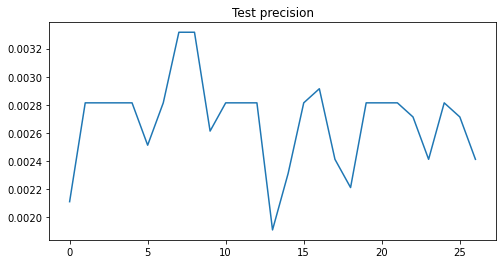

In [109]:
plt.figure(figsize=(8,4))
plt.plot(summary_heapsort['test_precision'])
plt.title('Test precision')

**Итого:** Сочетание числа компонент=10 с наиболее высоким learning_rate (0.10) и более высоким alpha (0.05 или 0.1) дает более высокое значение precision@5 на тестовой выборке (0.003317).